# Spatial snapshots and Xarray functions

---

## Overview
Calculating and plotting a time series of global mean anomaly serves as a useful way to highlight how to wield several xarray tools. Additionally, being able plot the spatial distribution of a property with an explicitly defined color scheme means never being at the mercy of the default colorbar again. 

1. Calculating global mean anomaly with Xarray
1. Filled contours superimposed on maps with Cartopy and Matplotlib

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 10 minutes

---

## Imports

In [23]:
%load_ext autoreload
%autoreload 2

import intake
import numpy as np

import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import pyleoclim as pyleo

## Calculating global mean anomaly 

In [3]:
# for AWS S3:
col = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")

In [4]:
query_d = dict(source_id='MIROC-ES2L', 
     experiment_id='historical', 
     grid_label='gn', 
     variable_id='pr', 
     member_id = 'r1i1p1f2',
     table_id='Amon'
    )

In [5]:
search_res = col.search(**query_d).to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [18]:
miroc_ds = list(search_res.values())[0]

In [19]:
miroc_ds

<xarray.Dataset>
Dimensions:         (lat: 64, bnds: 2, lon: 128, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon             (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 64, 128), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     pr
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC-E...
    intake_esm_attrs:version:         20190823
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MIROC.MIROC-ES2L.historical.Amon.gn

It is not uncommon for one set of units to be optimal for one calculation, but far less so for another. Below we'll make variables for precipitation rate in mm/day, time in years and latitude in radians following the form:
```
ds.assign(new_var_name = new_var_value)
```
*This is pretty much as one would expect except `new_var_name` will become the name of the variable (usually done with a string assignment) while here is assigned values in the style of a variable assignment. [There's a decent chance that if this footnote seemed obscure, you are unlikely to make the mistake it is addressing, so proceed with confidence!]*

In [20]:
# convert prate_mean from kg/(m^2*s) to mm/day
prate_unit_conversion = 86400
miroc_ds=miroc_ds.assign(pr_mmday=miroc_ds['pr'] * prate_unit_conversion)

In [21]:
# create a variable for year
miroc_ds = miroc_ds.assign(year=miroc_ds['time'].dt.year)


In [24]:
# create a variable for latitude in radians
miroc_ds= miroc_ds.assign(lat_rad=np.deg2rad(miroc_ds['lat']))


### Calculating anomalies

In some instances, it is useful to work with the central tendency (e.g. mean, or median) but in other cases we are interested in the anomaly--the residual between a value and some central tendency established using the full timeseries, or perhaps a reference interval. 

If we want to calculate the monthly anomaly relative to the reference interval 1900 to 1980:
1. calculate climatology for the interval 1900 to 1980
2. group data by month and subtract climatology

In [27]:
interval = [1900, 1980] 
interval_ds = miroc_ds.sel(time=(miroc_ds.time.dt.year < interval[1]) | 
                     (miroc_ds.time.dt.year >= interval[0]))

time_unit = 'time.month' #time_unit is a string
miroc_climatology = interval_ds.groupby(time_unit).mean("time")

In [31]:
pr_mmday_anom = (miroc_ds.groupby(time_unit) - miroc_climatology)['pr_mmday']
miroc_ds = miroc_ds.assign(pr_mmday_anom=pr_mmday_anom)

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


Alternatively, we could use `time.season` if we wanted seasonal anomaly instead of monthly anomaly... dealer's choice. 

In [ ]:
# wrapping these  steps into functions...
def calc_climatology(ds, time_unit='time.month', interval=None):
    if interval is None:
        interval_ds = ds
    else:
        interval_ds = ds.sel(time=(ds.time.dt.year < 1980) | (ds.time.dt.year >= 1900))
    climatology = interval_ds.groupby(time_unit).mean("time")
    return climatology

def remove_seasonality(ds, climatology, time_unit='time.month'):
    anomalies = ds.groupby(time_unit) - climatology
    return anomalies



### Calculating weighted means 

Sometimes it is practical to apply weights before doing a calculation. In addition to the many project-specific adjustments that exist, there are common instances in which we use bins--for example, a grid cell, or a month--that may each constitute an item on a list with equal weight in the eyes of a mathematical operator, but which as a practical matter should have different levels of influence on aggregate values. 

It may be tempting to simply apply `.mean()`, taking the average of all data for a given timestep, but not all grid cells cover the same area! (Indeed, the area of grid cells shrinks to 0 as one approaches the poles.) Happily, we can take advantage of one of Xarray's built in functions, `weighted` to correct for this and give the earth's curvature its due. 

- The `lat` coordinate is in degrees North, so we'll use Numpy, a core Python scientific computing package, to convert to radians and then take the cosine to arrive at a vector of latitude weights (weights).
- `weights` is a transformed version of `lat` so Xarray infers that it should be applied along the `lat` coordinate.

In [33]:
lat_weights = np.cos(np.deg2rad(miroc_ds.lat))
lat_weights.name = "lat_weights"

ds_lat_weighted = miroc_ds.weighted(lat_weights)
ds_global_mean = ds_lat_weighted.mean(("lon", "lat"))['pr_mmday_anom']

In [38]:
miroc_ds["pr_mmday_anom_gm"] = ("time", ds_global_mean.squeeze().data)

To make this more ingestable for plotting purposes, it helps to convert time to fractional years.

In [112]:
miroc_time_float = cftime.date2num(miroc_ds.time.data, 
                                   'months since 0-1-1',
                                    calendar='360_day', 
                                   has_year_zero=True)*1/12

In [113]:
import pyleoclim as pyleo
ps_month = pyleo.Series(time=miroc_time_float, 
                  value=miroc_ds["pr_mmday_anom_gm"].data, time_unit='year',
                  value_name='Precipitation anomaly (mm/day)',
                  clean_ts=False)


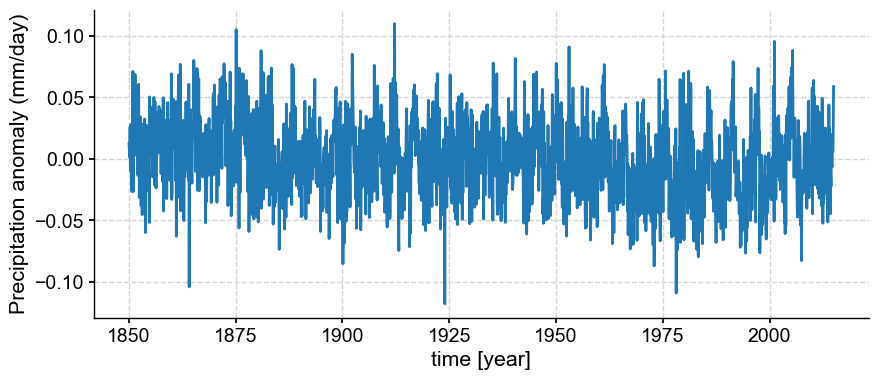

In [114]:
ps_month.plot();

### Annualizing

If we want to see less of the high frequency variability, we can take the final step of annualizing. 

In [86]:
def annualize(ds):
    ds_annualized = ds.groupby('time.year').mean('time')
    return ds_annualized

In [115]:
pr_mmday_anom_gm_annual = annualize(miroc_ds["pr_mmday_anom_gm"])

In [117]:
import pyleoclim as pyleo
ps_annual = pyleo.Series(time=pr_mmday_anom_gm_annual.year, 
                  value=pr_mmday_anom_gm_annual.squeeze().data, 
                  time_unit='year',
                  value_name='Precipitation anomaly (mm/day)',
                  clean_ts=False)


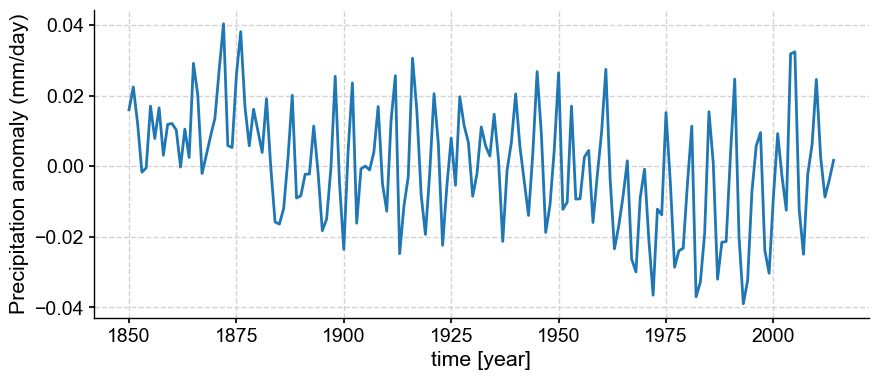

In [118]:
ps_annual.plot();

## Pcolor maps with Cartopy

Spatial snapshots with filled contours are useful ways of describing a snapshot in time. [This needs a better intro, or perhaps no intro at all.]

_Contour Map Elements_
1. Figure with a defined `projection` (map projection); add features (e.g. coastlines)
2. `add_cyclic_point`, putting data on a coordinate system that renders continuously between lon=360 and lon=0
3. Plot contour or contourf with `lonc`, lat, and data processed by the cyclic transform
4. Colorbar

In [129]:
month = 3
year = 1877
var = 'pr_mmday_anom'
colorbar_units = '[mm/day]'
title_copy = 'Precipitation Anomaly, {}/{} \n(ref. int: (1900-1980))'

In [130]:
snapshot_data = miroc_ds.isel(time=(miroc_ds.time.dt.year == year) & (miroc_ds.time.dt.month == month))


### Global precipitation anomaly (filled contours)

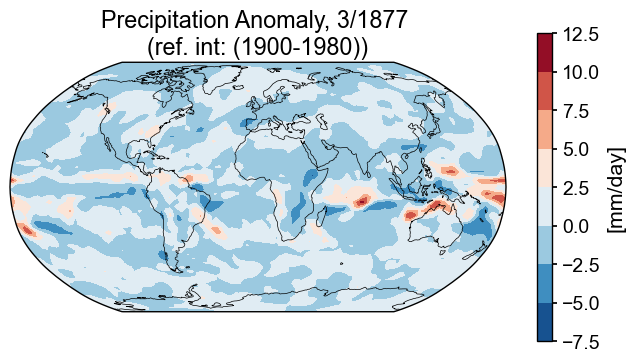

In [132]:
fig = plt.figure(figsize=(8, 4))

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data[var], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(), cmap='RdBu_r',
                   transform=ccrs.PlateCarree())

# add annotations (colorbar, title)
plt.colorbar(cf2, label=colorbar_units)
ax2.set_title(title_copy.format(month, year));


Not bad, but if we want to place this in a dashboard with other plots, it would help to have a colorbar that behaves predictably. One way to do that is to make a separate axis for a colorbar and then construct the colorbar from the contour information directly, rather than having matplotlib produce it as an afterthought. One of the ways matplotlib places colorbars is by allowing them to share a fraction of the plotting axis. This isn't particularly concerning when there is only one plot in the mix, but can become less tidy when there are multiple plots, each with a colorbar that requires a different amount of space for labelling, etc. 

Enter: `GridSpec`. The gridspec functionality in matplotlib improves the odds that objects of interest will reside in their assigned slots in a grid. Broadly, a grid includes information about the number of rows and columns, and optionally, about the size of each margin(`top`, `bottom`, `left`, `right`), the space between columns (`wspace`) or rows (`hspace`), and the relative sizes of rows `width_ratios` and columns (`height_ratios`).

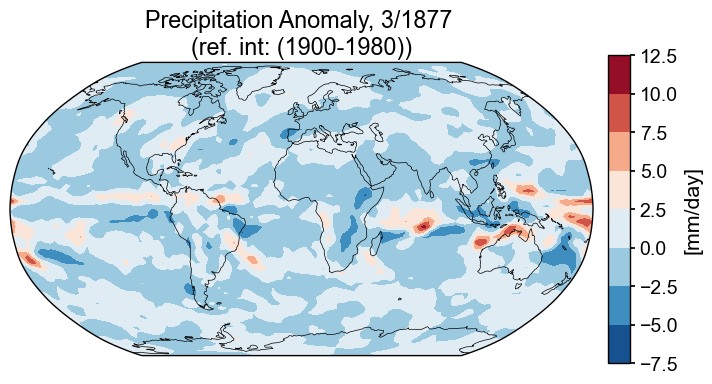

In [133]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 6:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data[var], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r')

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(cf2, cax = ax2_cb, orientation='vertical',label=colorbar_units)
ax2.set_title(title_copy.format(month, year));


That's an improvement. It would be possible to fiddle with the various knobs to arrive at whatever spacing seemed most comfortable, but this will suffice for the time being. 

However, if we want to dictate the specifics of the color scheme because we want to make sure that the range is tuned to cover multiple plots, or just because we disagree with matplotlib's best effort, we might be better served by explicitly defining and then mandating a colorbar. 

In the final version of this plot the colorbar is constructed by building a scale with 15 levels ranging between plus and minus the maximum amplitude. One of the shortcomings of the plot above is that 0 does not correspond to no color (white). Rather than following the default range, -7.5 to 12.5, we'll take  the maximum absolute value of the minimum and max and use it as the amplitude of the colorbar. If we dictate that the colorbar will have an odd number of levels, we will guarantee that 0 will be in the middle and all values will be covered. Of course, there is not "one size fits all" because different data are best served by different strategies, but this is one useful one. 

The `contourf` function requires information about the range of values, the color map, and how values are distributed across that color map. Collectively, this information is a `ScalarMappable`. Because we'll want to do this again later on, let's write a funcfion to do the task. 

In [134]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if n is None:
        ax_cmap = plt.get_cmap(cmap)
    else:    
        ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

### Global precip anomaly (filled contours) with precip contour lines

Now that we have the color scheme, we'll replot. 

In this final version, we'll add contours for the magnitude of monthly precipitation (as opposed to anomaly) to demonstrate how to add contour lines for another variable on top of the filled contours. This short function, `fmt` (adapted from matplotlib documentation) formats the labels for the contour lines. 

In [136]:
# establish scale
ax2_Li_1 = max([np.abs(snapshot_data[var].max().compute()), 
                np.abs(snapshot_data[var].min().compute())])
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

In [137]:

# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1"
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

In [135]:
nc = 21
zrange = 20

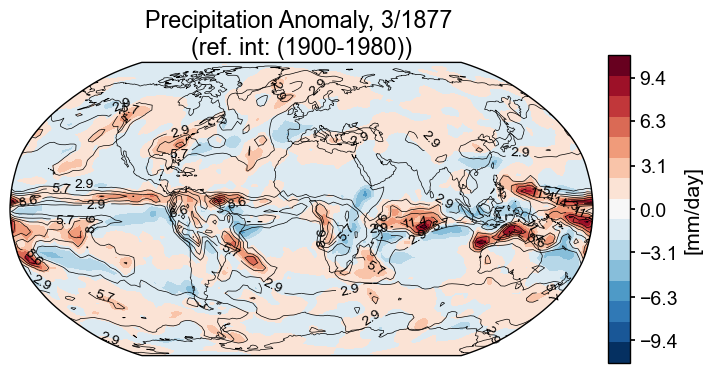

In [138]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data[var], snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                   transform=ccrs.PlateCarree(), **cf2_kwargs)
# add contours
zg_c , _ = cutil.add_cyclic_point(snapshot_data['pr_mmday'], snapshot_data['lon'])                     
cf2_lines = ax2.contour(lonc,snapshot_data['lat'], zg_c.squeeze(), np.linspace(-zrange,zrange,15),
                            colors='k',
                            transform=ccrs.PlateCarree(), linewidths=.5)
ax2.clabel(cf2_lines, cf2_lines.levels, inline=True, fmt=fmt, fontsize=10)

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units, 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     

ax2.set_title(title_copy.format(month, year));


---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!